In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
def excelreader(name,gain,correct):
    
    #initialise varibale
    
    time_points = 0 
    time_interval = 0
    
    #open the file 
    
    df_cellfree = pd.ExcelFile(name)
    
    # find the machine name to know where data start 
    
    test = pd.DataFrame(df_cellfree.parse(0))

    if re.search('Synergy',str(test.iloc[7,1])) == None :
        
        s = 64
        
        correction = [3720.7,39499,47364,192405]

    else: 
        s = 67
        
        correction = [5929.3,57884,73091,283567]
        
        
        
    #find the number of time points
    
    if s == 67:
        
        time_points = int(re.findall(r'\d+',test.iloc[17,1])[-1])
        time_interval = int(re.findall(r'\d+',test.iloc[17,1])[-3])

    else : 
        
        time_points = int(re.findall(r'\d+',test.iloc[16,1])[-1])
        time_interval = int(re.findall(r'\d+',test.iloc[16,1])[-3])
        
    # "crop" the table depending on the gain set 
    
    if gain == 50 :
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+12+(3*time_points):s+13+(4*time_points)])
        c = correction[0]
    elif gain == 70 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+8+(2*time_points):s+9+(3*time_points)])
        c = correction[1]
    elif gain == 75 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+4+time_points:s+5+(2*time_points)])
        c = correction[2]
    elif gain == 100 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s:s+1+time_points])
        c = correction[3]

    # Label first row as  column names
    df_Fcellfree.columns = df_Fcellfree.iloc[0]
    

    # Drop the first row (Which is column names)
    df_Fcellfree = df_Fcellfree.iloc[1: , :]
    
    
    # Drop the First Column ---> Generates "NAN column"
    df_Fcellfree = df_Fcellfree.iloc[: , 1:]
    
    
    remove = np.asarray(df_Fcellfree.columns)
    
    
    df_Fvalues = df_Fcellfree.reset_index().drop([remove[0],remove[1],'index'],axis = 1).astype('float64')
    
    
    if correct == "NO":
        df_Fvalues = df_Fvalues  
    else:
        df_Fvalues = df_Fvalues/c # the calibration to go back to µM 
    
    time_list = [0]
    n_rows = df_Fvalues.shape[0]
    time = 0
    
    #create a column with the time
    
    for i in range(n_rows):
        time += time_interval
        time_list.append(time)

    df_Tvalues = pd.DataFrame([time_list]).transpose().rename(columns={0:'Time'})
    
    df_Fvalues['Time'] = df_Tvalues['Time']
    
    #return the final table
    
    return (df_Fvalues)

In [3]:
def plot_raw_data(data,nr,nc):
    fig,axs = plt.subplots(nr, nc, sharex = True, sharey = True,figsize=(30, 30))
    counter = 0
    for i in range(nr):
        for j in range(nc):
            axs[i,j].plot(data['Time'],data[data.columns[counter]])
            counter+=1
        #plt.ylim(0,0.9)
    plt.show()

In [4]:
def collapse(data,tripl,control):
    
    #create a variable with names of the columns
    
    col=[]
    name =[]
    
    for ch in data.columns[:-1]:
        col.append(ch)

    #if the imput is line then the triplicate are a list of the column name 3 by 3 
    
    if tripl == 'line': 

        i = 0
        j = 0
        while i < round((len(col)/3),0):
            name.append([col[j],col[j+1],col[j+2]])
            i= i +1
            j = j+3 
            
    elif tripl == 'col':
        
        #create a list of the repeating letters
        duplicates = []
        for char in re.findall('[a-zA-Z]',str(col)):
            ## checking whether the character have a duplicate or not
            ## str.count(char) returns the frequency of a char in the str
            if str(col).count(char) > 1:
                []
            ## appending to the list if it's already not present

            if char not in duplicates :

                duplicates.append(char)
        
        #create a list of the repeated number
        b = list(np.array_split(re.findall(r'\d+ ?',str(col)),len(duplicates))[0])

        #for each repeating number add the repeating letter 

        li = []

        for i in b :
            for j in duplicates :
                li.append(j+str(i))


        #create a list of list containing 3 by 3 the name of the previous list

        i = 0 
        j = 0
        name=[]
        
              
        while i < len(li)/3:
            name.append([li[j],li[j+1],li[j+2]])
            i= i +1
            j = j+3  

    else : 
        name = col
        
    pos = []
    collapse = name
    
    list_bg = control
    
    df_Fbg = data[list_bg]
    df_Fbg['mean'] = df_Fbg.mean(axis=1)
    
    for col,i in zip(collapse,range(len(collapse))):

        list_flu = collapse
        df_flu = data[col]
        df_flu['mean'] = df_flu.mean(axis=1)
        df_flu['cor'] = df_flu['mean']-df_Fbg['mean']

        # Build the Backgruond Table...
        # TIME
        df_flut = data['Time']

        # MEAN
        df_flut['mean'] = df_flu['mean']
        df_flut['cor'] = df_flu['cor']

        #df_flut.head()

        data[str(col)] = df_flut['cor']
    
    for i in range(len(name)):
        pos.append(str(name[i]))
    
    df_Fcollapse = data[pos]
    df_Fcollapse['Time'] = data['Time']
    
    df_Fcollapse[df_Fcollapse<0]=0
    
    return (df_Fcollapse)

In [5]:
def plot_triplicates(data,sa):
    std = []
    for i in data.columns:
        std.append(statistics.stdev(data[i]))

    if sa == "NO":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
    elif sa =="YES":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

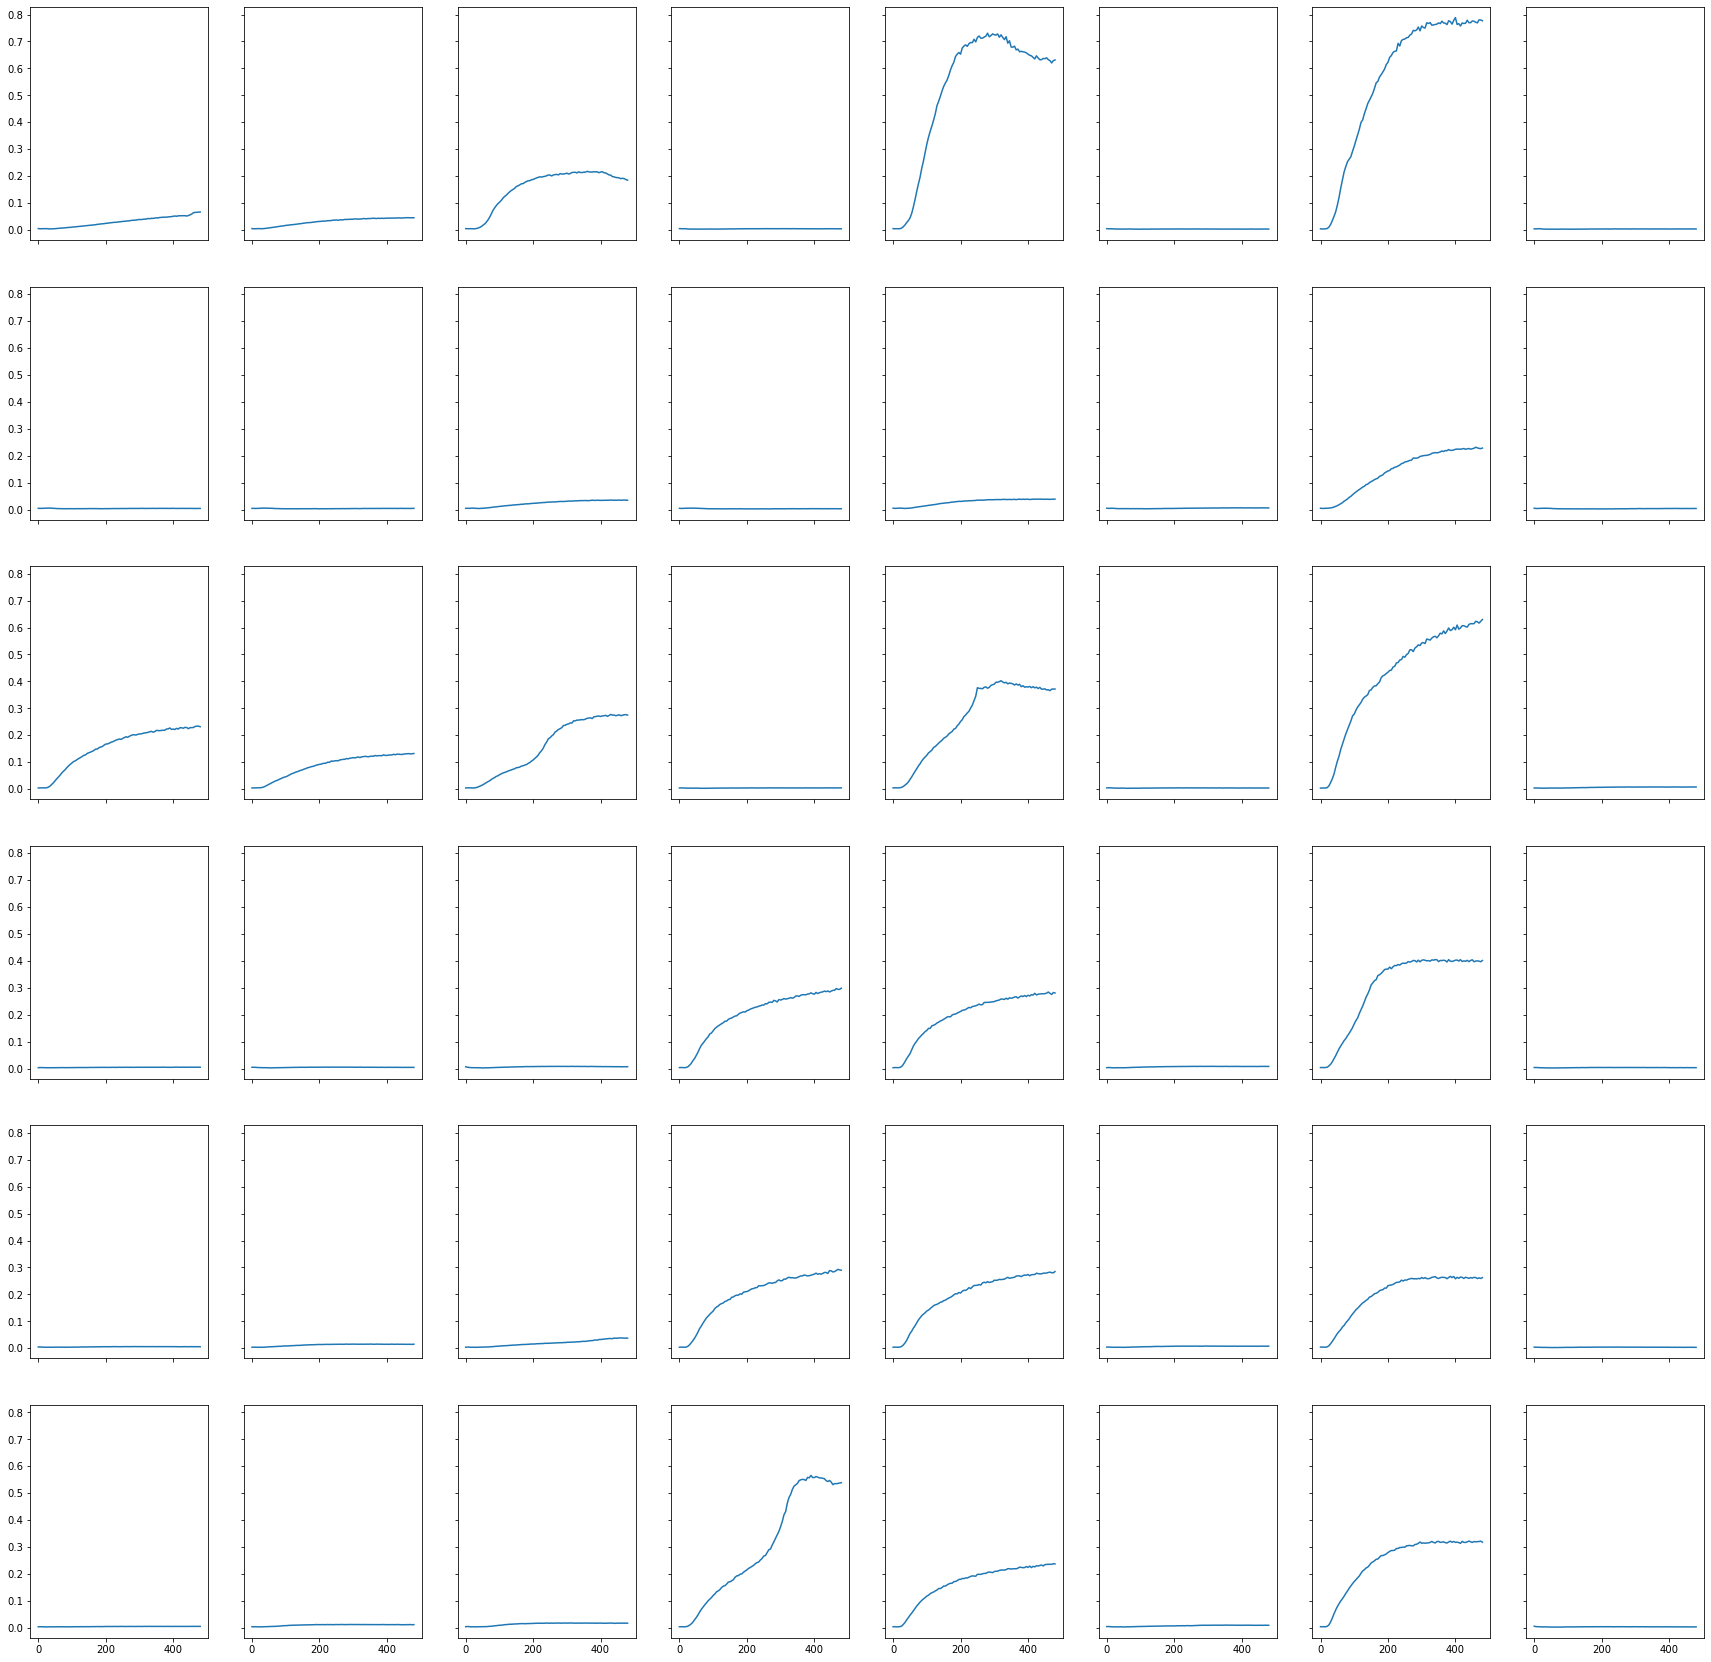

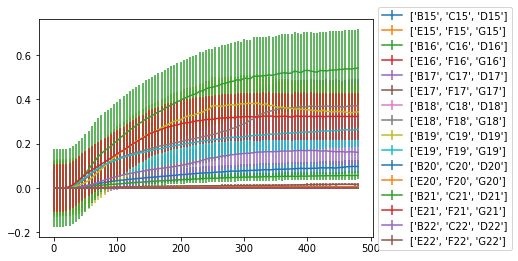

,"['B15', 'C15', 'D15']","['E15', 'F15', 'G15']","['B16', 'C16', 'D16']","['E16', 'F16', 'G16']","['B17', 'C17', 'D17']","['E17', 'F17', 'G17']","['B18', 'C18', 'D18']","['E18', 'F18', 'G18']","['B19', 'C19', 'D19']","['E19', 'F19', 'G19']","['B20', 'C20', 'D20']","['E20', 'F20', 'G20']","['B21', 'C21', 'D21']","['E21', 'F21', 'G21']","['B22', 'C22', 'D22']","['E22', 'F22', 'G22']",Time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000292,0.000000,0.000000,0.000105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,0.000369,0.000196,0.000251,0.000205,0.000502,0.000625,0.000301,0.000000,0.000383,0.000014,0.000315,0.000246,0.000000,0.000036,0.000000,0.0,5
2,0.000474,0.000000,0.000315,0.000219,0.000616,0.000379,0.000351,0.000000,0.000702,0.000000,0.000556,0.000073,0.000014,0.000036,0.000205,0.0,10
3,0.001104,0.000233,0.001090,0.000438,0.001172,0.000169,0.000848,0.000091,0.001113,0.000141,0.000949,0.000000,0.000825,0.000369,0.000643,0.0,15
4,0.001391,0.000246,0.001450,0.000347,0.001240,0.000337,0.000953,0.000962,0.001546,0.000985,0.000725,0.000046,0.001897,0.002007,0.000702,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.095420,0.001998,0.056838,0.006800,0.162254,0.017394,0.000488,0.366885,0.343024,0.263708,0.001044,0.004980,0.538375,0.323597,0.001687,0.0,460
93,0.097126,0.001902,0.056997,0.006850,0.163623,0.017248,0.000488,0.370214,0.340553,0.262540,0.001008,0.004976,0.536158,0.322739,0.001578,0.0,465
94,0.097504,0.002070,0.056405,0.007000,0.163691,0.017179,0.000410,0.370894,0.339672,0.260360,0.001104,0.005030,0.537690,0.323505,0.001751,0.0,470
95,0.097942,0.002002,0.056924,0.006690,0.162765,0.017084,0.000493,0.370716,0.342778,0.263288,0.001003,0.004976,0.539433,0.322484,0.001728,0.0,475


In [7]:
def main(data,gain,cor,nr,nc,tripl,control,sa):
    
    file = excelreader(data,gain,cor)
    
    plot_raw_data(file,nr,nc)
    
    fileC = collapse(file,tripl,control)
    
    plot_triplicates(fileC,sa)
    
    return fileC

#test

main('example/data/11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")
